Логистическая регрессия — это алгоритм, решающий задачу классификации, который используется для прогнозирования вероятности категориальной зависимой переменной. В логистической регрессии зависимая переменная — это двоичная переменная, которая содержит данные, закодированные как 1 (да, успех и т. д.) или 0 (нет, неудача и т. д.). Другими словами, модель предсказывает P(Y=1) как функцию от X.

Попробуем применить логорегрессию на табличных данных, взятых [отсюда](http://archive.ics.uci.edu/ml/index.php)

Будем предсказывать, оформит ли клиент банка вклад, в зависимости от 20 параметров.

In [ ]:
"""
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
"""

'\nimport pandas as pd\nimport numpy as np\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn import metrics\nfrom sklearn.metrics import classification_report\n'

Сейчас ячейка выше полностью закомментирована.
Это сделано потому, что библиотеки в дальнейшем коде я буду подключать постепенно, чтобы не запутаться. Но когда вы будете писать собственный код, лучше всё импортировать уже "в шапке".

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(35377, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [ ]:
import numpy as np

In [ ]:
# следующие три строчки - просто "причёсывание" данных
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
data.head() # выводим первые 5 строк таблицы

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1.0,999.0,0.0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0.0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1.0,999.0,0.0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0.0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3.0,6.0,2.0,success,-1.7,94.055,-39.8,0.729,4991.6,1.0
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0.0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,1.0,3.0,1.0,success,-2.9,92.201,-31.4,0.869,5076.2,1.0


#### Переменные на вход - параметры



1 - возраст (numeric)

2 - работа : тип профессии (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - семейное положение (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - уровень образования (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: есть ли дефолт по кредиту? (categorical: 'no','yes','unknown') - Дефолт - это когда вы не можете оплатить ожидаемый долг

6 - housing: есть ли жилищный кредит? (categorical: 'no','yes','unknown')

7 - loan: есть ли личный кредит? (categorical: 'no','yes','unknown')

8 - контакты (categorical: 'cellular','telephone')

9 - month: в каком месяце последний раз выходил на связь (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: в какой день недели последний раз выходил на связь (categorical: 'mon','tue','wed','thu','fri')

11 - duration: продолжительность последнего контакта в секундах (numeric).

12 - campaign: количество контактов, выполненных во время этой кампании и для этого клиента (numeric, includes last contact)

13 - pdays: количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (numeric; 999 means client was not previously contacted)

14 - previous: количество контактов, выполненных до этой кампании и для этого клиента (numeric)

15 - poutcome: результат предыдущей маркетинговой кампании (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: коэффициент изменения занятости - (numeric)

17 - cons.price.idx: индекс потребительских цен - (numeric)

18 - cons.conf.idx: индекс доверия потребителей - (numeric)

19 - euribor3m: трёхмесячная ставка - (numeric)

20 - nr.employed: количество сотрудников - (numeric)


#### Предсказываемая переменная (целевая):

y - оформит ли клиент срочный вклад? (binary: '1','0')

In [ ]:
data['y'].value_counts() # посмотрим, какое у нас соотношение в метках

0.0    31367
1.0     4010
Name: y, dtype: int64

In [ ]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("процент неуспеха", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("процент успеха", pct_of_sub*100)

процент неуспеха 88.66495180484496
процент успеха 11.335048195155045


Видим, что 36548 из звонков клиентам закончились неуспехом, а 4640 - успехом.

Наши классы несбалансированы, и соотношение экземпляров без подписки к экземплярам с подпиской составляет 89:11.

Это значит, что модель лучше научится опознавать неуспех.

Ниже попробуем сбалансировать данные, используя алгоритм SMOTE (создание псевдоданных)

Для начала, очищу данные от нечисловых значений. Вместо них создадим бинарные переменные, по типу "месяц_май", имеющие два возможных значения - 0 или 1. Так, вместо одной переменной "месяц" будут созданы 12 побочный бинарных переменных.


In [ ]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]

In [ ]:
X = data.drop(['y', 'job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], axis='columns')
y = data['y']

In [ ]:
X.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210.0,1.0,999.0,0.0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,138.0,1.0,999.0,0.0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,339.0,3.0,6.0,2.0,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,185.0,2.0,999.0,0.0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,137.0,1.0,3.0,1.0,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# посмотрим, как изменилось количество данных
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  43886
Number of no subscription in oversampled data 21943
Number of subscription 21943
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


Теперь нужно выделить наиболее показательные признаки

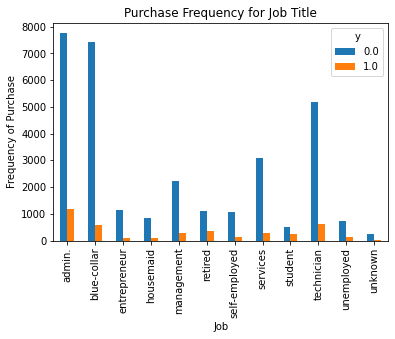

In [ ]:
import matplotlib.pyplot as plt

pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

In [ ]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate',
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]
X=os_data_X[cols]
y=os_data_y['y']

Теперь у нас есть идеально сбалансированные данные! Вы, возможно, заметили, что "увеличены" только обучающие данные.

Теперь подключим саму модель

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

Ура! Мы её обучили. Всего-то!

Теперь посмотрим, насколько хорошо на обучилась. Вспомним метрики.

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      7666
           1       0.88      0.78      0.83      7675

    accuracy                           0.84     15341
   macro avg       0.84      0.84      0.84     15341
weighted avg       0.84      0.84      0.84     15341



А вообще, что за цифры? Попробуем вывеси результаты наглядно:

In [ ]:
res = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
res.head()

,y_test,y_pred
29155,1,1
38810,1,0
9276,0,0
11274,0,0
35663,1,1
